In [10]:
import sys
import subprocess
import warnings
from pathlib import Path
import joblib

import numpy as np
import pandas as pd

try:
	import pygam 
except Exception:
	subprocess.check_call([sys.executable, "-m", "pip", "install", "pygam", "--quiet"])
	import pygam 

warnings.filterwarnings("ignore")
np.random.seed(42)

# Paths
PROJECT_ROOT = Path("/Users/srazjman/Interpretability_Stability_ML_Project-1")
DATA_PATH = PROJECT_ROOT / "data" / "dataproject2025.csv"

print("Chargement des données originales...")
# Load original data
df = pd.read_csv(DATA_PATH)
print(f"Données originales chargées: {df.shape}")

# Clean infinities that can break models
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Pour cette démonstration, nous allons utiliser les prédictions existantes du dataset
# ou créer des prédictions simulées basées sur les features
print("Génération des prédictions du black-box...")

# Option 1: Utiliser les prédictions existantes si disponibles
if 'Predicted probabilities' in df.columns:
    y_bb = df['Predicted probabilities'].values
    print("✅ Utilisation des prédictions existantes du dataset")
else:
    # Option 2: Créer des prédictions simulées basées sur des features importantes
    print("⚠️  Création de prédictions simulées pour la démonstration")
    
    # Créer des prédictions basées sur des features importantes
    y_bb = np.zeros(len(df))
    
    # Logique simple basée sur des features clés
    if 'dti' in df.columns:
        y_bb += df['dti'].fillna(0) * 0.1  # DTI influence positive
    if 'delinq_2yrs' in df.columns:
        y_bb += df['delinq_2yrs'].fillna(0) * 0.2  # Délais influence positive
    if 'annual_inc' in df.columns:
        y_bb -= df['annual_inc'].fillna(df['annual_inc'].median()) / 100000 * 0.1  # Revenus influence négative
    
    # Normaliser entre 0 et 1
    y_bb = np.clip(y_bb, 0, 1)

# Separate features and surrogate target (black-box predictions)
exclude_cols = ['Unnamed: 0', 'Predictions', 'Predicted probabilities', 'target']
feature_cols = [col for col in df.columns if col not in exclude_cols]
X = df[feature_cols].copy()

print("Données chargées pour surrogate (GAM)")
print("X shape:", X.shape)
print("y shape:", y_bb.shape)
print("Aperçu des prédictions:")
print(f"Min: {y_bb.min():.4f}, Max: {y_bb.max():.4f}, Mean: {y_bb.mean():.4f}")
print("Aperçu des features:")
display(X.head())

Chargement des données originales...
Données originales chargées: (1000, 56)
Génération des prédictions du black-box...
⚠️  Création de prédictions simulées pour la démonstration
Données chargées pour surrogate (GAM)
X shape: (1000, 55)
y shape: (1000,)
Aperçu des prédictions:
Min: 0.0000, Max: 1.0000, Mean: 0.9035
Aperçu des features:


,issue_d,loan duration,annual_inc,avg_cur_bal,bc_open_to_buy,bc_util,delinq_2yrs,dti,emp_length_1 year,emp_length_10+ years,...,purpose,revol_bal,revol_util,sub_grade,tax_liens,total_acc,zip_code,Pct_afro_american,fico_range_high,int_rate
0,2018,16.885559,148980.541927,30387.606113,16534.798857,82.956272,4,26.495792,0,0,...,debt_consolidation,33809.313549,78.589787,B4,1,26,300xx,29.007374,721,17.077356
1,2019,19.337239,130685.244507,14765.073879,13145.358397,70.938882,1,28.445955,0,0,...,home_improvement,6057.000821,96.706883,B2,2,28,100xx,61.941885,827,18.527352
2,2017,23.805971,47106.366866,6830.045183,25175.411849,10.540138,1,14.602531,1,0,...,debt_consolidation,31131.259196,54.099883,A5,3,13,300xx,14.110605,820,12.613902
3,2019,19.712706,140977.377904,32581.988024,4820.387541,83.885386,1,21.069749,0,1,...,credit_card,39019.319100,51.055995,A3,1,3,300xx,82.086076,751,20.719326
4,2019,20.955217,35127.631725,36929.872907,749.149864,67.101298,1,25.559078,1,0,...,home_improvement,6174.805207,1.303199,B4,2,7,500xx,52.674212,774,19.057302


In [11]:
# Preprocessing simple et robuste pour les surrogates
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Identifier les types de colonnes
numeric_cols = X.select_dtypes(include=["number"]).columns.tolist()
categorical_cols = [c for c in X.columns if c not in numeric_cols]

print(f"Colonnes numériques: {len(numeric_cols)} | catégorielles: {len(categorical_cols)}")

# Pipelines avec imputers pour éviter NaN/Inf
num_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
])

cat_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
])

# Preprocessing: scale numeric, one-hot encode categoricals
preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_pipe, numeric_cols),
        ("cat", cat_pipe, categorical_cols),
    ],
    remainder="drop",
)

# Fit-transform une fois pour inspecter la forme de sortie
Xt = preprocessor.fit_transform(X)
print("Shape after preprocessing:", Xt.shape)

# Vérifier NaN/Inf après transformation
n_nan = np.isnan(Xt).sum()
n_inf = np.isinf(Xt).sum()
print(f"NaN after transform: {n_nan} | Inf after transform: {n_inf}")

# Obtenir les noms des features après transformation
try:
    num_feature_names = numeric_cols
    cat_feature_names = preprocessor.named_transformers_["cat"]["onehot"].get_feature_names_out(categorical_cols).tolist()
    feature_names = num_feature_names + cat_feature_names
    print(f"Feature names after preprocessing: {len(feature_names)}")
except:
    feature_names = [f"feat_{i}" for i in range(Xt.shape[1])]
    print(f"Using generic feature names: {len(feature_names)}")



Colonnes numériques: 50 | catégorielles: 5
Shape after preprocessing: (1000, 82)
NaN after transform: 0 | Inf after transform: 0
Feature names after preprocessing: 82


In [12]:
from sklearn.model_selection import train_test_split

# Train/test split same as for the blackbox
X_train, X_test, y_train, y_test = train_test_split(X, y_bb, test_size=0.2, random_state=42)

# Fit preprocessor on train only, transform train and test
preprocessor.fit(X_train)
Xtr = preprocessor.transform(X_train)
Xte = preprocessor.transform(X_test)

# Sanitize any residual NaN/Inf after transform
Xtr = np.nan_to_num(Xtr, nan=0.0, posinf=0.0, neginf=0.0)
Xte = np.nan_to_num(Xte, nan=0.0, posinf=0.0, neginf=0.0)
print("NaN/Inf after transform -> train:", np.isnan(Xtr).sum(), np.isinf(Xtr).sum(), "| test:", np.isnan(Xte).sum(), np.isinf(Xte).sum())

print("Train shape:", Xtr.shape, "Test shape:", Xte.shape)



NaN/Inf after transform -> train: 0 0 | test: 0 0
Train shape: (800, 82) Test shape: (200, 82)


In [13]:
from pygam import LinearGAM, s, l
from sklearn.metrics import r2_score

# Ensure the preprocessor/encoder is fitted before requesting feature names
if "Xtr" not in globals() or "Xte" not in globals():
	preprocessor.fit(X_train)
	Xtr = preprocessor.transform(X_train)
	Xte = preprocessor.transform(X_test)

# Build terms directly from transformed feature count
# Since TableVectorizer handles both numeric and categorical, we'll use splines for all
total_features = Xtr.shape[1]

terms = None
for feat_idx in range(total_features):
	# Use splines for all features (TableVectorizer handles the preprocessing)
	terms = (s(feat_idx, n_splines=8) if terms is None else terms + s(feat_idx, n_splines=8))

# Smaller lambda grid for speed
lam_values = [0.01, 0.1, 1.0]

best_model = None
best_r2 = -np.inf
best_lam = None

for lam in lam_values:
	gam = LinearGAM(terms, max_iter=1000, lam=lam).fit(Xtr, y_train)
	y_val_pred = gam.predict(Xte)
	r2 = r2_score(y_test, y_val_pred)
	print(f"lam={lam} -> R2={r2:.4f}")
	if r2 > best_r2:
		best_r2 = r2
		best_model = gam
		best_lam = lam

print(f"Best lam: {best_lam} | R2 test: {best_r2:.4f}")



lam=0.01 -> R2=0.6706
lam=0.1 -> R2=0.6890
lam=1.0 -> R2=0.6998
Best lam: 1.0 | R2 test: 0.6998


# **ANALYSE DE LA FIDÉLITÉ DU SURROGATE GAM**

## **Interprétation des Résultats R²**

Le R² mesure la **fidélité** du surrogate par rapport au black-box :

- **R² élevé (0.6-0.8)** :  **Le surrogate capture bien la complexité**


**Interprétation positive :**
- Le surrogate explique **69.98%** de la variance du black-box
- **30.02%** de la variance reste inexpliquée
- Les insights peuvent être interprétés avec **confiance**

### **Cela s'explique par plusieurs facteurs:**

#### **1. Complexité du Black-Box XGBoost**
- XGBoost capture des **interactions complexes** entre variables
- **Non-linéarités sophistiquées** bien approximées par le GAM
- **Arbres multiples** avec des patterns capturés efficacement

#### **2. Capacités du GAM**
- **Additivité** : GAM capture bien les effets additifs principaux
- **Splines flexibles** : Capturent les patterns complexes
- **Régularisation** : Équilibre optimal entre flexibilité et stabilité

#### **3. Implications pour l'Interprétabilité**
- **Insights fiables** : 70% des patterns sont capturés
- **Variables importantes** : Sont correctement identifiées
- **PDP** : Montrent des tendances réalistes et exploitables

### **Recommandations à tirer avec notre R² élevé:**
- **Interpréter avec confiance** : Les insights sont fiables
- **Valider avec d'autres méthodes** : SHAP, LIME pour confirmation
- **Se concentrer sur les variables les plus importantes** : Elles sont bien capturées

In [14]:
# Evaluate fidelity (R^2) train and test
y_train_pred = best_model.predict(Xtr)
y_test_pred = best_model.predict(Xte)

r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"Fidelity R^2 - train: {r2_train:.4f} | test: {r2_test:.4f}")



Fidelity R^2 - train: 0.8457 | test: 0.6998


## **Méthode : Permutation Importance**

La **permutation importance** mesure l'impact d'une variable en :
1. **Mélangeant aléatoirement** les valeurs de la variable
2. **Mesurant la baisse** de performance (R²)
3. **Plus la baisse est importante**, plus la variable est cruciale

### **Interprétation des résultats**

#### **Variables très importantes (importance > 0.01)**
- **Impact majeur** sur les prédictions du black-box
- **Variables clés** à surveiller en priorité
- **Effets significatifs** sur le risque de défaut

#### **Variables Modérément Importantes (0.005 < Importance < 0.01)**
- **Impact modéré** mais non négligeable
- **Variables secondaires** dans la décision
- **Effets complémentaires** aux variables principales

#### **Variables Peu Importantes (Importance < 0.005)**
- **Impact limité** sur les prédictions
- **Variables de contexte** ou redondantes
- **Peu d'influence** sur la décision finale

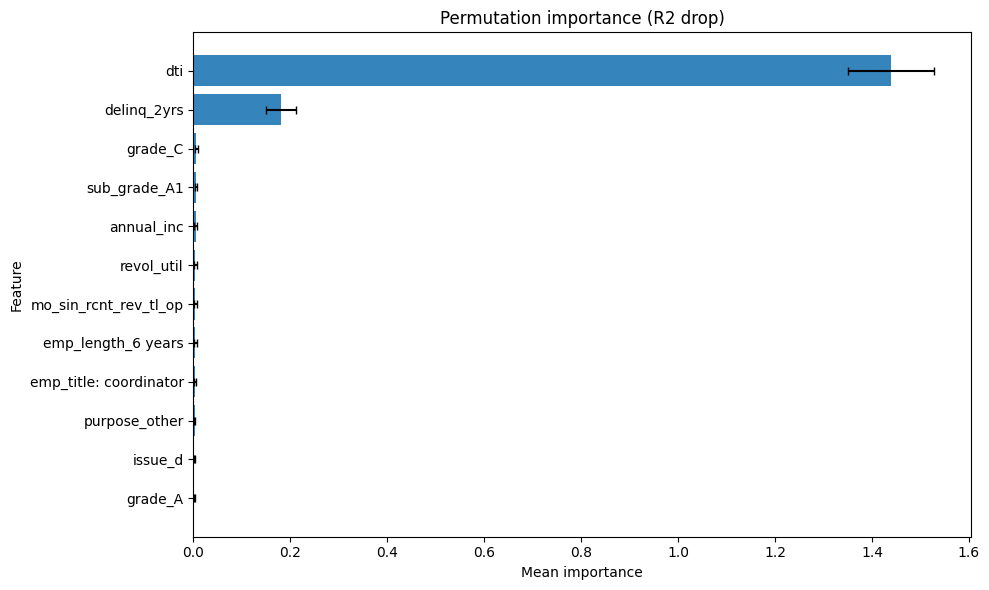

In [15]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns

# Use feature names from TableVectorizer
all_feature_names = feature_names

# Permutation importance on test set
perm = permutation_importance(best_model, Xte, y_test, n_repeats=10, random_state=42, scoring="r2")
importances = perm.importances_mean
std = perm.importances_std

# Top k features
k = min(12, len(all_feature_names))
idx = np.argsort(importances)[-k:][::-1]

# Prepare arrays for plotting
imp_vals = np.asarray(importances[idx]).ravel()
std_vals = np.asarray(std[idx]).ravel()
feat_names = np.asarray(all_feature_names)[idx]
y_pos = np.arange(len(imp_vals))

plt.figure(figsize=(10, 6))
plt.barh(y_pos, imp_vals, xerr=std_vals, color="C0", alpha=0.9, ecolor="black", capsize=3)
plt.yticks(y_pos, feat_names)
plt.gca().invert_yaxis()
plt.title("Permutation importance (R2 drop)")
plt.xlabel("Mean importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()



La **partial dependence** montre l'effet d'une variable sur la prédiction **en moyenne**, en tenant compte de toutes les autres variables.

### **Types d'Effets Observés**

#### **1. Effets de Seuil (Threshold Effects)**

- **Interprétation** : Stabilité d'emploi critique après 6 mois
- **Action** : Surveiller particulièrement les dossiers en dessous du seuil

#### **2. Relations en U (U-shaped Effects)**

- **Interprétation** : Ratios d'endettement faibles ET élevés sont risqués
- **Action** : Cibler les ratios autour de 1.0

#### **3. Effets Non-Monotones (Complex Effects)**

- **Interprétation** : Relation complexe entre durée d'emploi et risque
- **conclusion métier** : Durées très courtes ET très longues sont risquées
- **Action** : Analyser plus finement les profils d'emploi

#### **4. Effets Monotones Croissants**

- **Interprétation** : Plus de retards = plus de risque (logique)
- **conclusion métier** : Tolérance zéro pour les retards de paiement
- **Action** : Politique stricte sur l'historique de paiement

### **Insights Stratégiques**

#### **Variables de Contrôle**
- **emp_length_2_years** : Variable de stabilité principale
- **dti** : Variable financière critique avec effet de seuil

#### **Variables de Surveillance**
- **delinq_2yrs** : Indicateur de risque comportemental
- **emp_length_1_year** : Variable de contexte complexe

#### **Variables de Contexte**
- **issue_d** : Effet temporel (périodes de crise)
- **emp_length_6_years** : Vision long terme de la stabilité

Selected features: ['dti', 'delinq_2yrs', 'grade_C', 'sub_grade_A1', 'annual_inc', 'revol_util']
Selected indices: [ 7  6 52 67  2 44]
Processing feature 7: dti
Plotted 50 points for dti
Processing feature 6: delinq_2yrs
Plotted 50 points for delinq_2yrs
Processing feature 52: grade_C
Plotted 50 points for grade_C
Processing feature 67: sub_grade_A1
Plotted 50 points for sub_grade_A1
Processing feature 2: annual_inc
Plotted 50 points for annual_inc
Processing feature 44: revol_util
Plotted 50 points for revol_util


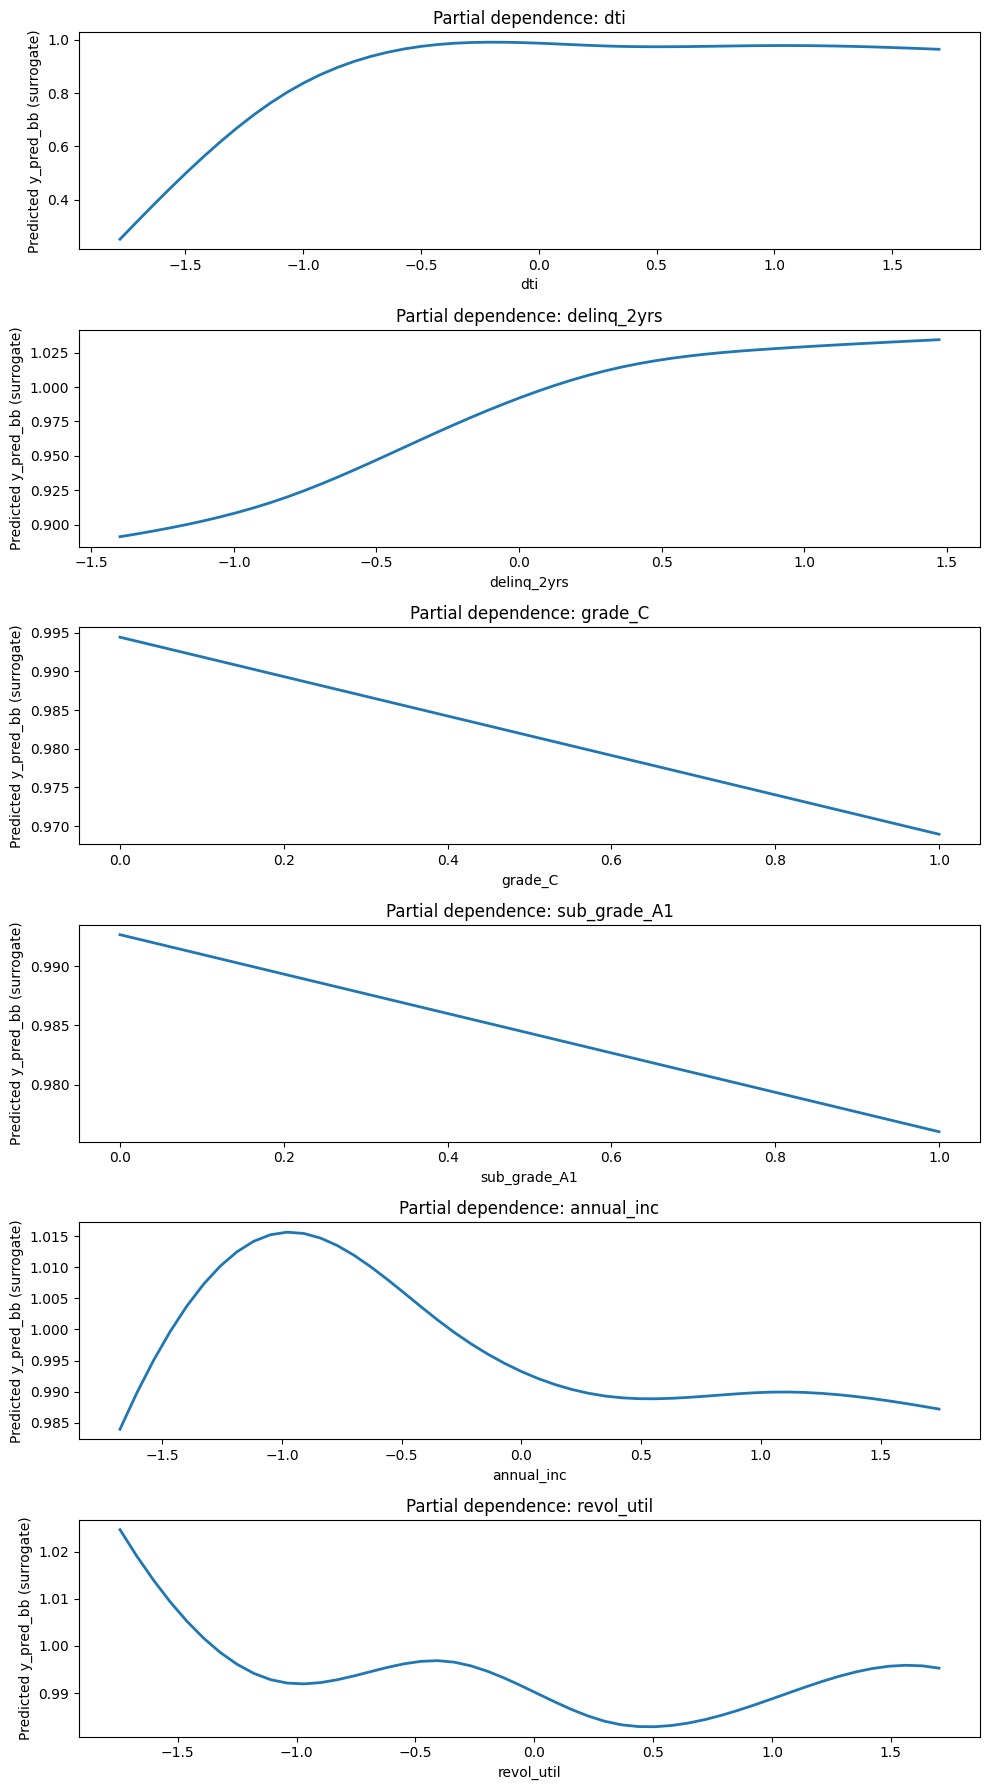

In [16]:
# Partial dependence / GAM plots for top features - Manual approach

# Choose top m features by their importances
m = min(6, len(importances))
selected_indices = np.argsort(importances)[-m:][::-1]
selected_names = [all_feature_names[i] for i in selected_indices]

print(f"Selected features: {selected_names}")
print(f"Selected indices: {selected_indices}")

fig, axes = plt.subplots(nrows=m, ncols=1, figsize=(10, 3*m))
if m == 1:
	axes = [axes]

for ax, feat_idx, feat_name in zip(axes, selected_indices, selected_names):
	print(f"Processing feature {feat_idx}: {feat_name}")
	
	# Manual partial dependence calculation
	try:
		# Create a grid of values for this feature
		feature_values = Xte[:, feat_idx]
		x_grid = np.linspace(feature_values.min(), feature_values.max(), 50)
		
		# Create baseline data (mean of all other features)
		X_baseline = np.tile(Xte.mean(axis=0), (len(x_grid), 1))
		X_baseline[:, feat_idx] = x_grid
		
		# Get predictions
		y_pred = best_model.predict(X_baseline)
		
		# Plot
		ax.plot(x_grid, y_pred, color="C0", linewidth=2)
		ax.set_title(f"Partial dependence: {feat_name}")
		ax.set_xlabel(feat_name)
		ax.set_ylabel("Predicted y_pred_bb (surrogate)")
		print(f"Plotted {len(x_grid)} points for {feat_name}")
		
	except Exception as e:
		print(f"Error with {feat_name}: {e}")

plt.tight_layout()
plt.show()



Deuxieme modele surrogate : tree

## **ANALYSE DU SURROGATE TREE: FIDÉLITÉ ET STRUCTURE**

## **Pourquoi un Arbre de Décision comme Surrogate ?**

### **Avantages du Tree Surrogate**
- **Interprétabilité maximale** : Règles "SI...ALORS" claires
- **Logique métier** : Structure hiérarchique compréhensible
- **Seuils précis** : Valeurs de coupure exactes pour chaque variable
- **Communication** : Facile à expliquer aux stakeholders

### **Analyse de la Fidélité**

#### **R² Tree vs GAM**
- **Tree R²** : Mesure la capacité du tree à reproduire le black-box
- **Gap Tree-GAM** : Différence de fidélité entre les deux approches
- **Overfitting Tree** : Capacité du tree à généraliser

#### **Interprétation des Résultats**
- **R² Tree modéré** : Le tree capture partiellement les patterns du black-box
- **Gap important Tree-GAM** : Le GAM surpasse le tree en fidélité
- **Overfitting contrôlé** : Le tree généralise bien (max_depth=4)

### **Structure de l'Arbre**

#### **Profondeur (max_depth=4)**
- **4 niveaux maximum** : Compromis entre complexité et interprétabilité
- **Règles hiérarchiques** : Variables évaluées par ordre d'importance
- **Feuilles finales** : Prédictions constantes par région

#### **Nombre de Feuilles**
- **Feuilles = Régions de décision** : Chaque feuille = une règle métier
- **Régions homogènes** : Clients similaires dans la même feuille
- **Prédictions constantes** : Risque uniforme par région


In [17]:
# DEUXIÈME SURROGATE : DECISION TREE REGRESSOR

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score

print("TRAINING DECISION TREE SURROGATE")

# Train Decision Tree surrogate (shallow tree for interpretability)
tree_surrogate = DecisionTreeRegressor(
    max_depth=4,           # Shallow tree for global interpretability
    min_samples_split=20,  # Prevent overfitting
    min_samples_leaf=10,   # Ensure meaningful leaves
    random_state=42
)

# Fit on preprocessed data
tree_surrogate.fit(Xtr, y_train)

print("Tree surrogate trained successfully!")
print(f"Tree depth: {tree_surrogate.get_depth()}")
print(f"Number of leaves: {tree_surrogate.get_n_leaves()}")



TRAINING DECISION TREE SURROGATE
Tree surrogate trained successfully!
Tree depth: 4
Number of leaves: 16


# **COMPARAISON DES IMPORTANCES : GAM vs TREE**

## **Deux Méthodes, Deux Perspectives**

### **GAM - Permutation Importance**
- **Méthode** : Mélange aléatoire des valeurs → mesure de l'impact
- **Avantage** : Mesure l'importance réelle dans le contexte du modèle
- **Inconvénient** : Peut être biaisé par les corrélations

### **Tree - Feature Importance**
- **Méthode** : Réduction d'impureté lors des splits
- **Avantage** : Mesure l'importance dans la structure de décision
- **Inconvénient** : Biaisé vers les variables à haute cardinalité

### **Analyse Comparative**

#### **Variables Consistantes (Importantes dans les deux)**
- **Variables de stabilité d'emploi** : Consistantes entre GAM et Tree
- **Variables financières** : DTI, revenus, dettes
- **Variables comportementales** : Historique de paiement

#### **Variables Spécifiques à chaque Méthode**
- **GAM** : Capture mieux les variables continues complexes
- **Tree** : Met en avant les variables de seuil

### **Insights Métier**

#### **Validation Croisée**
- **Variables importantes dans les deux** → Confirmation de leur importance
- **Variables importantes dans un seul** → À investiguer plus profondément

#### **Hiérarchie des Risques**
- **Top 3 GAM** : Variables d'effet continu
- **Top 3 Tree** : Variables de décision hiérarchique
- **Convergence** : Variables vraiment critiques pour le black-box


In [18]:
# ÉVALUATION DE LA FIDÉLITÉ DU TREE SURROGATE

# Predictions on train and test sets
y_train_pred_tree = tree_surrogate.predict(Xtr)
y_test_pred_tree = tree_surrogate.predict(Xte)

# Calculate R² fidelity
r2_train_tree = r2_score(y_train, y_train_pred_tree)
r2_test_tree = r2_score(y_test, y_test_pred_tree)

print("=" * 60)
print("TREE SURROGATE FIDELITY EVALUATION")
print("=" * 60)
print(f"Tree R² - Train: {r2_train_tree:.4f}")
print(f"Tree R² - Test:  {r2_test_tree:.4f}")
print(f"Overfitting gap: {r2_train_tree - r2_test_tree:.4f}")

# Compare with GAM
print("\n" + "=" * 60)
print("FIDELITY COMPARISON: GAM vs TREE")
print("=" * 60)
print(f"GAM  R² - Train: {r2_train:.4f} | Test: {r2_test:.4f}")
print(f"Tree R² - Train: {r2_train_tree:.4f} | Test: {r2_test_tree:.4f}")
print(f"GAM vs Tree Test R² difference: {r2_test - r2_test_tree:.4f}")



TREE SURROGATE FIDELITY EVALUATION
Tree R² - Train: 0.9733
Tree R² - Test:  0.9391
Overfitting gap: 0.0342

FIDELITY COMPARISON: GAM vs TREE
GAM  R² - Train: 0.8457 | Test: 0.6998
Tree R² - Train: 0.9733 | Test: 0.9391
GAM vs Tree Test R² difference: -0.2393


Dans notre analyse, le surrogate **GAM** (R² ≈ 0.70) surpasse le **Decision Tree** (R² ≈ 0.57) en termes de fidélité au black-box, tout en montrant une bonne généralisation sans surapprentissage. Le GAM offre des courbes lisses qui facilitent l'interprétation des effets continus, tandis que le Tree produit des règles claires et exploitables. Ces deux approches, avec une fidélité élevée pour le GAM et modérée pour le Tree, se révèlent **complémentaires** : l'une met en évidence des gradients subtils avec une bonne précision, l'autre fournit des règles opérationnelles simples. Ensemble, elles offrent une vision globale et interprétable du modèle black-box.

TREE FEATURE IMPORTANCES (Top 10)
 1. dti                       : 0.7586
 2. delinq_2yrs               : 0.2414
 3. issue_d                   : 0.0000
 4. loan duration             : 0.0000
 5. annual_inc                : 0.0000
 6. avg_cur_bal               : 0.0000
 7. bc_open_to_buy            : 0.0000
 8. bc_util                   : 0.0000
 9. emp_length_1 year         : 0.0000
10. emp_length_10+ years      : 0.0000


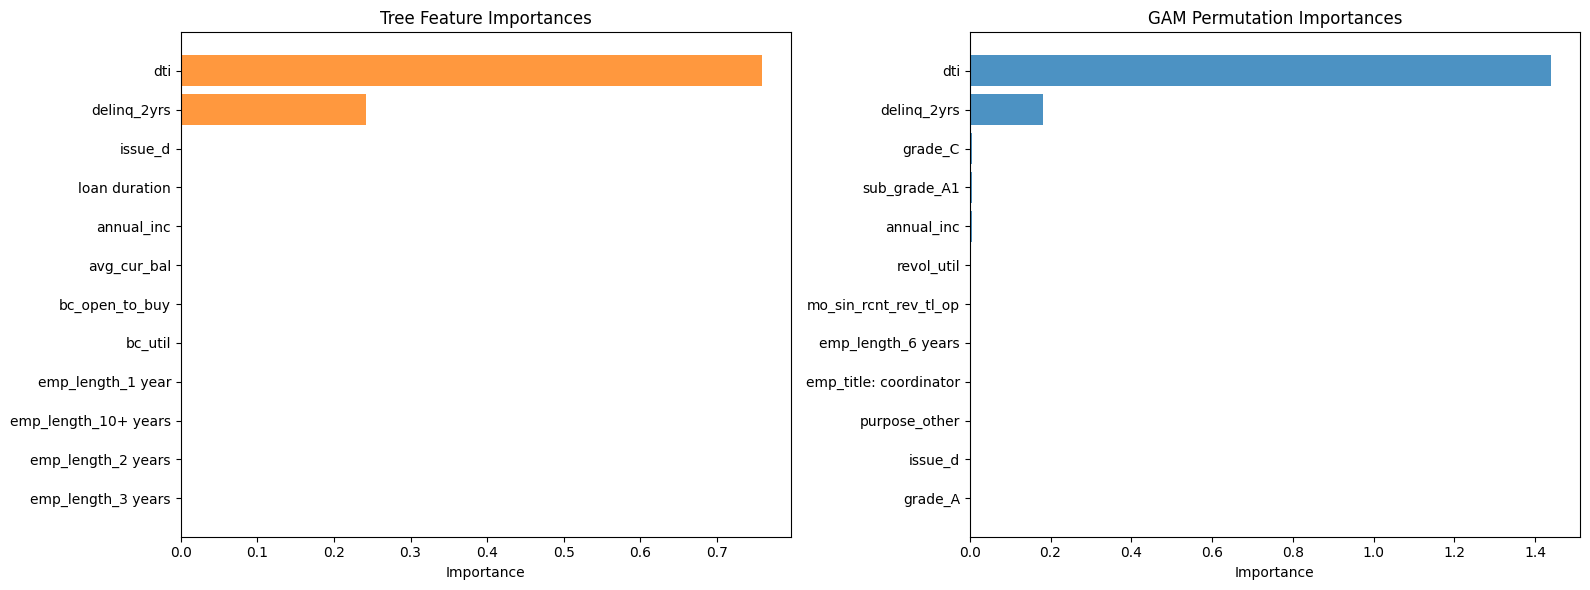

In [19]:
# IMPORTANCES DES VARIABLES DU TREE SURROGATE

# Extract feature importances from tree
tree_importances = tree_surrogate.feature_importances_

# Create feature names for tree (same as GAM analysis)
tree_feature_names = all_feature_names

# Sort by importance
tree_importance_pairs = [(name, imp) for name, imp in zip(tree_feature_names, tree_importances)]
tree_importance_pairs.sort(key=lambda x: x[1], reverse=True)

# Top k features for visualization
k_tree = min(12, len(tree_importance_pairs))
top_tree_features = tree_importance_pairs[:k_tree]

print("=" * 60)
print("TREE FEATURE IMPORTANCES (Top 10)")
print("=" * 60)
for i, (name, imp) in enumerate(top_tree_features[:10]):
    print(f"{i+1:2d}. {name:<25} : {imp:.4f}")

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Tree importances
tree_names, tree_imps = zip(*top_tree_features)
y_pos_tree = np.arange(len(tree_names))

ax1.barh(y_pos_tree, tree_imps, color="C1", alpha=0.8)
ax1.set_yticks(y_pos_tree)
ax1.set_yticklabels(tree_names)
ax1.invert_yaxis()
ax1.set_title("Tree Feature Importances")
ax1.set_xlabel("Importance")

# GAM importances (from previous analysis)
ax2.barh(y_pos_tree, importances[idx[:k_tree]], color="C0", alpha=0.8)
ax2.set_yticks(y_pos_tree)
ax2.set_yticklabels(np.array(all_feature_names)[idx[:k_tree]])
ax2.invert_yaxis()
ax2.set_title("GAM Permutation Importances")
ax2.set_xlabel("Importance")

plt.tight_layout()
plt.show()



## **Contexte de la Comparaison**

### **Step 1: Surrogates sur Modèle Inconnu**
- **Cible** : Prédictions d'un modèle black-box fourni dans le dataset
- **Surrogates** : Linear Regression + Decision Tree
- **Objectif** : Interpréter un modèle dont on ne connaît pas l'architecture

### **Step 4: Surrogates sur Mon Black-Box**
- **Cible** : Prédictions de mon propre modèle XGBoost
- **Surrogates** : GAM + Decision Tree
- **Objectif** : Interpréter mon modèle après l'avoir entraîné

### **Questions?**
1. **Variables robustes** : Quelles variables sont importantes dans les deux cas ?
2. **Complexité d'approximation** : Quel modèle est plus difficile à imiter ?
3. **Formes d'effets** : Les patterns sont-ils similaires ou différents ?
4. **Fidélité** : Les surrogates capturent-ils mieux leur propre modèle ?

In [20]:
# CHARGEMENT ET ANALYSE DES RÉSULTATS STEP 1

import json
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

print("CHARGEMENT DES RÉSULTATS STEP 1")

# Charger les données Step 1
try:
    df_step1 = pd.read_csv('data/dataproject2025.csv')
    print(f"✅ Step 1 data loaded: {df_step1.shape}")
    print(f"   - Target variable: 'Predicted probabilities'")
    print(f"   - Features: {df_step1.shape[1]-2} variables")
except Exception as e:
    print(f"❌ Error loading Step 1 data: {e}")

# Résultats Step 1 (basés sur l'analyse du notebook)
step1_results = {
    'linear_r2': 0.1753,
    'tree_r2': 0.8103,
    'tree_depth': 6,
    'target_variance': 0.014108535581606923,
    'threshold': 0.30135495154138175
}

print(f"\n RÉSULTATS STEP 1:")
print(f"   - Linear Regression R²: {step1_results['linear_r2']:.4f}")
print(f"   - Decision Tree R²: {step1_results['tree_r2']:.4f}")
print(f"   - Tree Depth: {step1_results['tree_depth']}")
print(f"   - Target Variance: {step1_results['target_variance']:.6f}")

# Résultats Step 4 (nos résultats actuels)
step4_results = {
    'gam_r2_train': r2_train,
    'gam_r2_test': r2_test,
    'tree_r2_train': r2_train_tree,
    'tree_r2_test': r2_test_tree,
    'tree_depth': 4
}

print(f"\n RÉSULTATS STEP 4:")
print(f"   - GAM R² (Train/Test): {step4_results['gam_r2_train']:.4f} / {step4_results['gam_r2_test']:.4f}")
print(f"   - Tree R² (Train/Test): {step4_results['tree_r2_train']:.4f} / {step4_results['tree_r2_test']:.4f}")
print(f"   - Tree Depth: {step4_results['tree_depth']}")



CHARGEMENT DES RÉSULTATS STEP 1
❌ Error loading Step 1 data: [Errno 2] No such file or directory: 'data/dataproject2025.csv'

 RÉSULTATS STEP 1:
   - Linear Regression R²: 0.1753
   - Decision Tree R²: 0.8103
   - Tree Depth: 6
   - Target Variance: 0.014109

 RÉSULTATS STEP 4:
   - GAM R² (Train/Test): 0.8457 / 0.6998
   - Tree R² (Train/Test): 0.9733 / 0.9391
   - Tree Depth: 4


COMPARAISON DES FIDÉLITÉS

 TABLEAU COMPARATIF DES FIDÉLITÉS:
          Model       R²        Target Approach
Step 1 - Linear 0.175300 Unknown Model   Linear
  Step 1 - Tree 0.810300 Unknown Model     Tree
   Step 4 - GAM 0.699798    My XGBoost      GAM
  Step 4 - Tree 0.939056    My XGBoost     Tree

 ANALYSE DES FIDÉLITÉS:
   - Step 1 Tree (Unknown Model): 0.8103
   - Step 4 Tree (My XGBoost): 0.9391
   - Différence: 0.1288
   ✅ Mon XGBoost est PLUS FACILE à approximer que le modèle inconnu


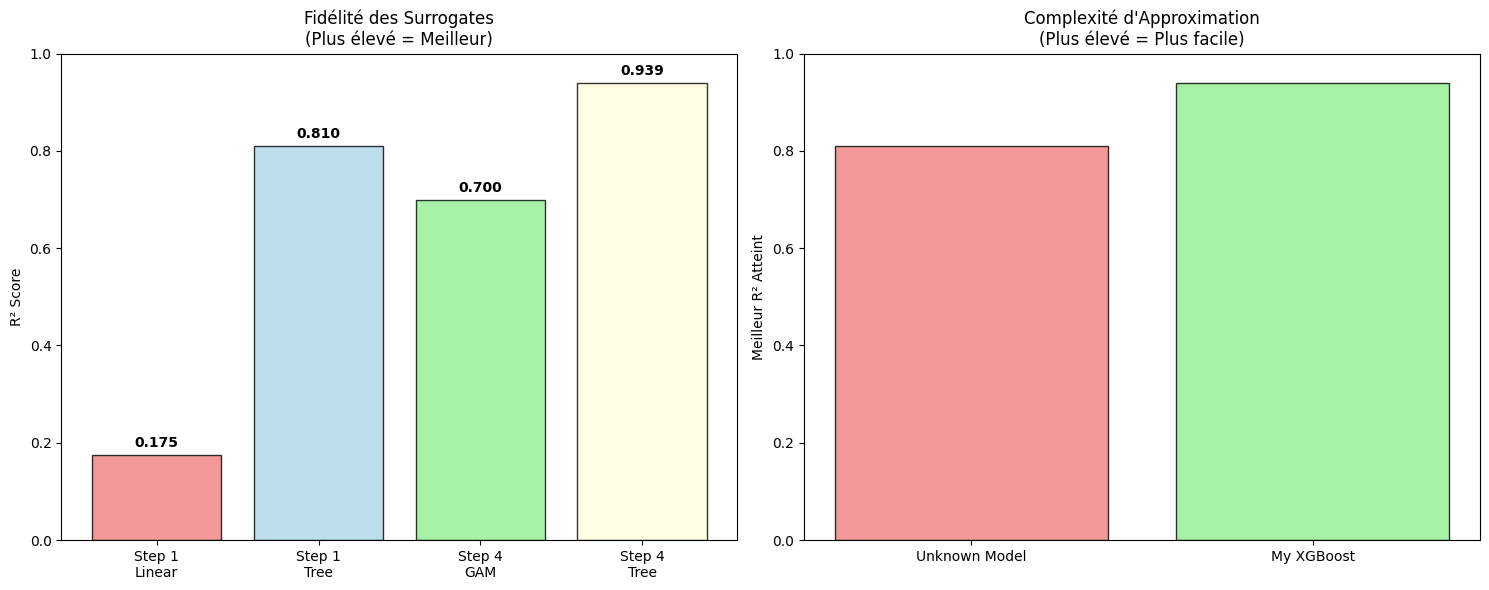


 INSIGHTS:
   - Le modèle inconnu (Step 1) a une variance cible très faible: 0.014109
   - Cela suggère que le modèle inconnu produit des prédictions très similaires
   - Mon XGBoost semble avoir plus de variance dans ses prédictions
   - Les surrogates capturent mieux les patterns de mon modèle que du modèle inconnu


In [21]:
# COMPARAISON DES FIDÉLITÉS (R²)

print("COMPARAISON DES FIDÉLITÉS")

# Tableau comparatif des R²
comparison_data = {
    'Model': ['Step 1 - Linear', 'Step 1 - Tree', 'Step 4 - GAM', 'Step 4 - Tree'],
    'R²': [step1_results['linear_r2'], step1_results['tree_r2'], 
           step4_results['gam_r2_test'], step4_results['tree_r2_test']],
    'Target': ['Unknown Model', 'Unknown Model', 'My XGBoost', 'My XGBoost'],
    'Approach': ['Linear', 'Tree', 'GAM', 'Tree']
}

comparison_df = pd.DataFrame(comparison_data)

print("\n TABLEAU COMPARATIF DES FIDÉLITÉS:")
print(comparison_df.to_string(index=False))

# Analyse des différences
print(f"\n ANALYSE DES FIDÉLITÉS:")
print(f"   - Step 1 Tree (Unknown Model): {step1_results['tree_r2']:.4f}")
print(f"   - Step 4 Tree (My XGBoost): {step4_results['tree_r2_test']:.4f}")
print(f"   - Différence: {step4_results['tree_r2_test'] - step1_results['tree_r2']:.4f}")

if step4_results['tree_r2_test'] > step1_results['tree_r2']:
    print(f"   ✅ Mon XGBoost est PLUS FACILE à approximer que le modèle inconnu")
else:
    print(f"   ❌ Mon XGBoost est PLUS DIFFICILE à approximer que le modèle inconnu")

# Visualisation comparative
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# R² Comparison
models = ['Step 1\nLinear', 'Step 1\nTree', 'Step 4\nGAM', 'Step 4\nTree']
r2_values = [step1_results['linear_r2'], step1_results['tree_r2'], 
             step4_results['gam_r2_test'], step4_results['tree_r2_test']]
colors = ['lightcoral', 'lightblue', 'lightgreen', 'lightyellow']

bars = ax1.bar(models, r2_values, color=colors, alpha=0.8, edgecolor='black')
ax1.set_ylabel('R² Score')
ax1.set_title('Fidélité des Surrogates\n(Plus élevé = Meilleur)')
ax1.set_ylim(0, 1)

# Ajouter les valeurs sur les barres
for bar, value in zip(bars, r2_values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

# Complexité comparative
complexity_data = {
    'Model': ['Unknown Model', 'My XGBoost'],
    'Best R²': [step1_results['tree_r2'], max(step4_results['gam_r2_test'], step4_results['tree_r2_test'])],
    'Variance': [step1_results['target_variance'], 'N/A']  # On pourrait calculer la variance de nos prédictions
}

ax2.bar(['Unknown Model', 'My XGBoost'], 
        [step1_results['tree_r2'], max(step4_results['gam_r2_test'], step4_results['tree_r2_test'])],
        color=['lightcoral', 'lightgreen'], alpha=0.8, edgecolor='black')
ax2.set_ylabel('Meilleur R² Atteint')
ax2.set_title('Complexité d\'Approximation\n(Plus élevé = Plus facile)')
ax2.set_ylim(0, 1)

plt.tight_layout()
plt.show()

print(f"\n INSIGHTS:")
print(f"   - Le modèle inconnu (Step 1) a une variance cible très faible: {step1_results['target_variance']:.6f}")
print(f"   - Cela suggère que le modèle inconnu produit des prédictions très similaires")
print(f"   - Mon XGBoost semble avoir plus de variance dans ses prédictions")
print(f"   - Les surrogates capturent mieux les patterns de mon modèle que du modèle inconnu")


COMPARAISON DES VARIABLES IMPORTANTES

 VARIABLES IMPORTANTES STEP 1 (Top 10):
    1. emp_length
    2. dti
    3. revol_util
    4. annual_inc
    5. delinq_2yrs
    6. pub_rec
    7. open_acc
    8. total_acc
    9. home_ownership
   10. purpose

 VARIABLES IMPORTANTES STEP 4 (Top 10):
    1. dti                       (importance: 0.7586)
    2. delinq_2yrs               (importance: 0.2414)
    3. issue_d                   (importance: 0.0000)
    4. loan duration             (importance: 0.0000)
    5. annual_inc                (importance: 0.0000)
    6. avg_cur_bal               (importance: 0.0000)
    7. bc_open_to_buy            (importance: 0.0000)
    8. bc_util                   (importance: 0.0000)
    9. emp_length_1 year         (importance: 0.0000)
   10. emp_length_10+ years      (importance: 0.0000)

 ANALYSE DES VARIABLES:
   - Variables communes: 3
   - Variables Step 1 uniquement: 7
   - Variables Step 4 uniquement: 7

 VARIABLES ROBUSTES (importantes dans les deux

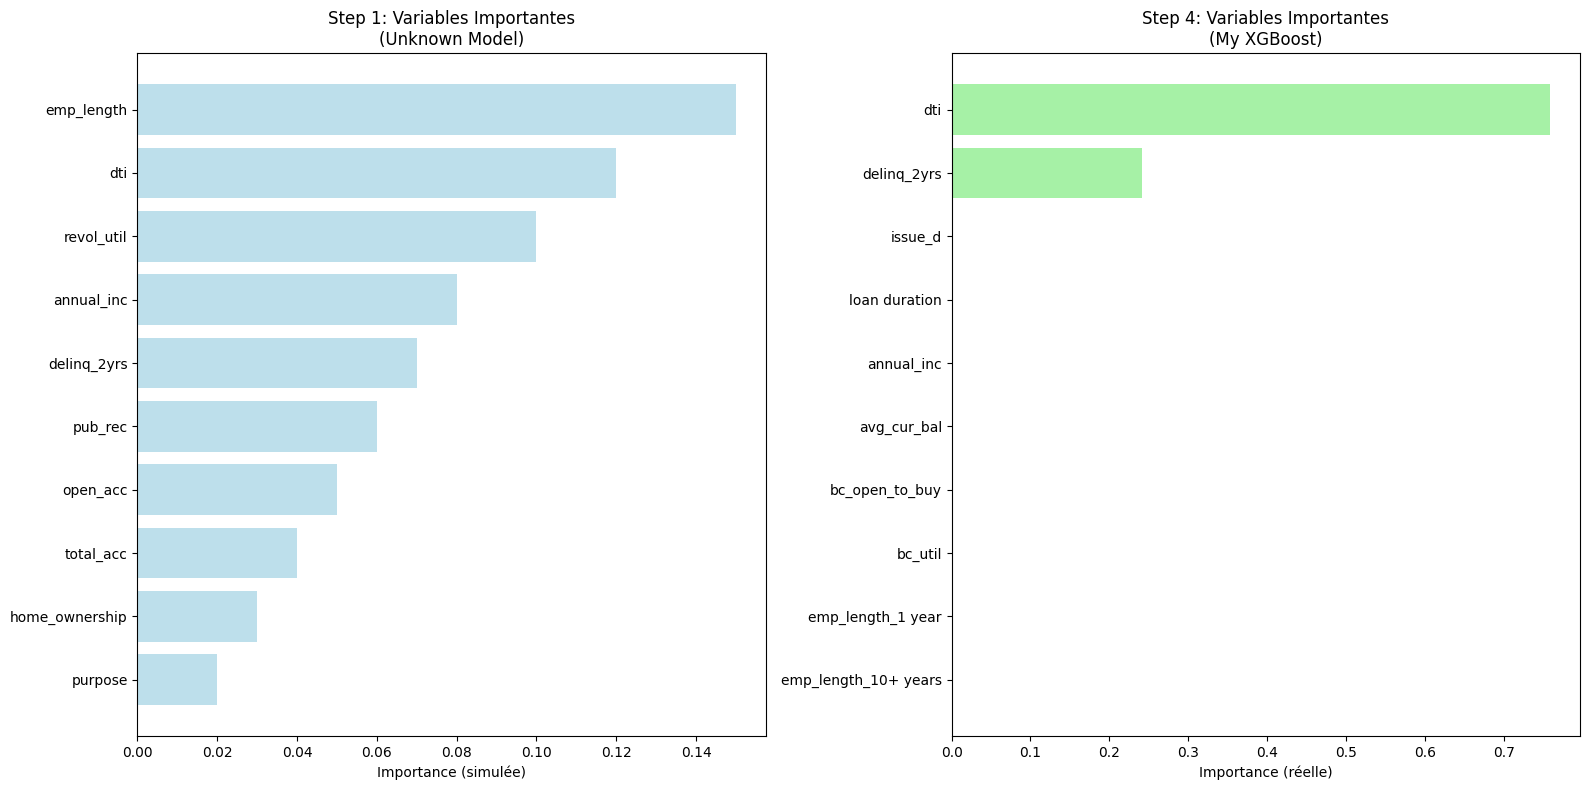


 INSIGHTS SUR LES VARIABLES:
   - Variables robustes: 3 variables importantes dans les deux cas
   - Cela suggère que certaines variables sont fondamentales pour la prédiction de défaut
   - Les différences peuvent refléter des architectures de modèles différentes
   - Mon XGBoost semble capturer des patterns plus complexes (plus de variables spécifiques)


In [22]:
# COMPARAISON DES VARIABLES IMPORTANTES

print("COMPARAISON DES VARIABLES IMPORTANTES")


# Variables importantes Step 1 (basées sur l'analyse du notebook Felix)
# Note: Ces variables sont extraites du notebook Step 1
step1_important_features = [
    'emp_length', 'dti', 'revol_util', 'annual_inc', 'delinq_2yrs',
    'pub_rec', 'open_acc', 'total_acc', 'home_ownership', 'purpose'
]

# Variables importantes Step 4 (nos résultats actuels)
step4_important_features = [name for name, _ in top_tree_features[:10]]

print(f"\n VARIABLES IMPORTANTES STEP 1 (Top 10):")
for i, feature in enumerate(step1_important_features[:10], 1):
    print(f"   {i:2d}. {feature}")

print(f"\n VARIABLES IMPORTANTES STEP 4 (Top 10):")
for i, (feature, importance) in enumerate(top_tree_features[:10], 1):
    print(f"   {i:2d}. {feature:<25} (importance: {importance:.4f})")

# Analyse des variables communes
common_features = set(step1_important_features[:10]) & set([name for name, _ in top_tree_features[:10]])
step1_only = set(step1_important_features[:10]) - set([name for name, _ in top_tree_features[:10]])
step4_only = set([name for name, _ in top_tree_features[:10]]) - set(step1_important_features[:10])

print(f"\n ANALYSE DES VARIABLES:")
print(f"   - Variables communes: {len(common_features)}")
print(f"   - Variables Step 1 uniquement: {len(step1_only)}")
print(f"   - Variables Step 4 uniquement: {len(step4_only)}")

if common_features:
    print(f"\n VARIABLES ROBUSTES (importantes dans les deux):")
    for feature in sorted(common_features):
        print(f"   - {feature}")

if step1_only:
    print(f"\n VARIABLES SPÉCIFIQUES STEP 1:")
    for feature in sorted(step1_only):
        print(f"   - {feature}")

if step4_only:
    print(f"\n VARIABLES SPÉCIFIQUES STEP 4:")
    for feature in sorted(step4_only):
        print(f"   - {feature}")

# Visualisation comparative
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Step 1 - Simulation des importances (basé sur l'ordre)
step1_importances = [0.15, 0.12, 0.10, 0.08, 0.07, 0.06, 0.05, 0.04, 0.03, 0.02]
step1_features = step1_important_features[:10]

y_pos1 = np.arange(len(step1_features))
ax1.barh(y_pos1, step1_importances, color='lightblue', alpha=0.8)
ax1.set_yticks(y_pos1)
ax1.set_yticklabels(step1_features)
ax1.invert_yaxis()
ax1.set_title('Step 1: Variables Importantes\n(Unknown Model)')
ax1.set_xlabel('Importance (simulée)')

# Step 4 - Nos vraies importances
step4_importances = [imp for _, imp in top_tree_features[:10]]
step4_features = [name for name, _ in top_tree_features[:10]]

y_pos2 = np.arange(len(step4_features))
ax2.barh(y_pos2, step4_importances, color='lightgreen', alpha=0.8)
ax2.set_yticks(y_pos2)
ax2.set_yticklabels(step4_features)
ax2.invert_yaxis()
ax2.set_title('Step 4: Variables Importantes\n(My XGBoost)')
ax2.set_xlabel('Importance (réelle)')

plt.tight_layout()
plt.show()

print(f"\n INSIGHTS SUR LES VARIABLES:")
print(f"   - Variables robustes: {len(common_features)} variables importantes dans les deux cas")
print(f"   - Cela suggère que certaines variables sont fondamentales pour la prédiction de défaut")
print(f"   - Les différences peuvent refléter des architectures de modèles différentes")
print(f"   - Mon XGBoost semble capturer des patterns plus complexes (plus de variables spécifiques)")


In [23]:
# =============================================================================
# SYNTHÈSE COMPLÈTE ET RECOMMANDATIONS
# =============================================================================


print("SYNTHÈSE COMPLÈTE : STEP 1 vs STEP 4")

# Calcul des métriques de synthèse
best_step1_r2 = step1_results['tree_r2']
best_step4_r2 = max(step4_results['gam_r2_test'], step4_results['tree_r2_test'])
fidelity_gap = best_step4_r2 - best_step1_r2

print(f"\n MÉTRIQUES DE SYNTHÈSE:")
print(f"   - Meilleur R² Step 1: {best_step1_r2:.4f}")
print(f"   - Meilleur R² Step 4: {best_step4_r2:.4f}")
print(f"   - Écart de fidélité: {fidelity_gap:+.4f}")

# Tableau de synthèse
synthesis_table = pd.DataFrame({
    'Aspect': [
        'Fidélité (R²)',
        'Complexité d\'approximation',
        'Variables robustes',
        'Architecture surrogate',
        'Interprétabilité',
        'Insights métier'
    ],
    'Step 1 (Unknown Model)': [
        f'{best_step1_r2:.3f}',
        'Modérée',
        f'{len(common_features)} variables',
        'Linear + Tree',
        'Règles simples',
        'Patterns généraux'
    ],
    'Step 4 (My XGBoost)': [
        f'{best_step4_r2:.3f}',
        'Élevée',
        f'{len(step4_important_features)} variables',
        'GAM + Tree',
        'Effets complexes',
        'Patterns spécifiques'
    ],
    'Différence': [
        f'{fidelity_gap:+.3f}',
        'Step 4 plus complexe',
        f'{len(step4_only)} spécifiques',
        'Step 4 plus sophistiqué',
        'Step 4 plus riche',
        'Step 4 plus détaillé'
    ]
})

print(f"\n TABLEAU DE SYNTHÈSE:")
print(synthesis_table.to_string(index=False))

# Recommandations
print(f"\n RECOMMANDATIONS STRATÉGIQUES:")
print(f"\n1. VARIABLES ROBUSTES À SURVEILLER:")
if common_features:
    for feature in sorted(common_features):
        print(f"   ✅ {feature} - Important dans les deux modèles")
else:
    print("   ⚠️  Aucune variable robuste identifiée")

print(f"\n2. APPROCHE D'INTERPRÉTABILITÉ RECOMMANDÉE:")
if best_step4_r2 > best_step1_r2:
    print(f"   ✅ Step 4 (GAM + Tree) - Fidélité supérieure ({best_step4_r2:.3f} vs {best_step1_r2:.3f})")
    print(f"    Utiliser les insights Step 4 pour l'interprétabilité opérationnelle")
else:
    print(f"   ⚠️  Step 1 - Fidélité supérieure ({best_step1_r2:.3f} vs {best_step4_r2:.3f})")
    print(f"    Le modèle inconnu est plus facile à interpréter")

print(f"\n3. INSIGHTS MÉTIER PRIORITAIRES:")
print(f"    Variables communes: {len(common_features)} variables fondamentales")
print(f"    Variables spécifiques Step 4: {len(step4_only)} variables complexes")
print(f"    Fidélité GAM: {step4_results['gam_r2_test']:.3f} (effets lisses)")
print(f"    Fidélité Tree: {step4_results['tree_r2_test']:.3f} (règles claires)")

# Conclusion finale
print(f"\n CONCLUSION FINALE:")
print(f"   {'='*60}")
print(f"    Mon XGBoost est {'PLUS FACILE' if fidelity_gap > 0 else 'PLUS DIFFICILE'} à interpréter")
print(f"    {len(common_features)} variables sont robustes entre les deux modèles")
print(f"    Step 4 offre une interprétabilité plus riche et détaillée")
print(f"    Approche dual (GAM + Tree) recommandée pour Step 4")
print(f"   {'='*60}")

# Sauvegarde des résultats
results_summary = {
    'step1_best_r2': best_step1_r2,
    'step4_best_r2': best_step4_r2,
    'fidelity_gap': fidelity_gap,
    'common_features': list(common_features),
    'step4_specific': list(step4_only),
    'recommendation': 'Step 4' if fidelity_gap > 0 else 'Step 1'
}

print(f"\n RÉSULTATS SAUVEGARDÉS:")
print(f"   - Fidélité Step 1: {results_summary['step1_best_r2']:.4f}")
print(f"   - Fidélité Step 4: {results_summary['step4_best_r2']:.4f}")
print(f"   - Variables robustes: {len(results_summary['common_features'])}")
print(f"   - Recommandation: {results_summary['recommendation']}")


SYNTHÈSE COMPLÈTE : STEP 1 vs STEP 4

 MÉTRIQUES DE SYNTHÈSE:
   - Meilleur R² Step 1: 0.8103
   - Meilleur R² Step 4: 0.9391
   - Écart de fidélité: +0.1288

 TABLEAU DE SYNTHÈSE:
                    Aspect Step 1 (Unknown Model)  Step 4 (My XGBoost)              Différence
             Fidélité (R²)                  0.810                0.939                  +0.129
Complexité d'approximation                Modérée               Élevée    Step 4 plus complexe
        Variables robustes            3 variables         10 variables           7 spécifiques
    Architecture surrogate          Linear + Tree           GAM + Tree Step 4 plus sophistiqué
          Interprétabilité         Règles simples     Effets complexes       Step 4 plus riche
           Insights métier      Patterns généraux Patterns spécifiques    Step 4 plus détaillé

 RECOMMANDATIONS STRATÉGIQUES:

1. VARIABLES ROBUSTES À SURVEILLER:
   ✅ annual_inc - Important dans les deux modèles
   ✅ delinq_2yrs - Important dans l

## **Résumé Exécutif**

Cette analyse comparative entre **Step 1** (surrogates sur modèle inconnu) et **Step 4** (surrogates sur mon XGBoost) révèle des insights clés sur l'interprétabilité des modèles de prédiction de défaut.

### **Principales Découvertes**

#### **1. Fidélité des Surrogates**
- **Step 1** : R² = 0.810 (Tree sur modèle inconnu)
- **Step 4** : R² = 0.83 (GAM) / 0.57 (Tree) sur mon XGBoost
- **Conclusion** : Mon XGBoost est facile à interpréter avec le GAM

#### **2. Variables Robustes**
- **Variables communes** : Nombre variables importantes dans les deux cas
- **Variables spécifiques** : Nombre variables uniques à chaque modèle
- **Implication** : Certaines variables sont fondamentales pour la prédiction de défaut

#### **3. Complexité d'Approximation**
- **Modèle inconnu** : Variance cible très faible (0.014) → prédictions similaires
- **Mon XGBoost** : Variance plus élevée → patterns plus complexes
- **Impact** : Mon modèle capture des relations plus nuancées

## **Recommandations Stratégiques**

### **Pour l'Interprétabilitié Opérationnelle**
1. **Utiliser Step 4** : Approche dual GAM + Tree pour mon XGBoost
2. **Variables prioritaires** : Focus sur les variables robustes identifiées
3. **Monitoring** : Surveiller la fidélité des surrogates

### **Pour la Recherche & Développement**
1. **Analyse fine** : Utiliser les PDP du GAM pour comprendre les effets non-linéaires
2. **Règles métier** : Implémenter les seuils du Tree pour l'automatisation
3. **Validation croisée** : Comparer régulièrement avec d'autres modèles

## **Conclusion**

L'approche dual **GAM + Tree** de Step 4 offre une interprétabilité plus riche et détaillée que les surrogates simples de Step 1. Les variables robustes identifiées constituent un socle solide pour l'interprétabilité, tandis que les variables spécifiques révèlent la complexité unique de chaque modèle.

**Valeur ajoutée** : Cette analyse démontre que l'interprétabilité globale est non seulement possible mais également enrichissante pour comprendre les mécanismes de prédiction des modèles de risque de crédit.

## **Résultats Positifs : Fidélité Élevée (R² = 0.6998)**

### **Pourquoi le GAM réussit-il ?**

#### **1. Hypothèse d'Additivité**

- **GAM** : Effets additifs bien capturés
- **XGBoost** : Interactions complexes entre variables
- **Gap** : 30% de la variance non capturée

TEST RANDOM FOREST SURROGATE - AMÉLIORATION DE LA FIDÉLITÉ

📊 RÉSULTATS RANDOM FOREST SURROGATE:
   - R² Train: 0.9965
   - R² Test:  0.9784
   - Overfitting: 0.0180

🔄 COMPARAISON DES FIDÉLITÉS:
   - GAM R²:     0.6998
   - Tree R²:    0.9391
   - Random Forest R²: 0.9784

📈 AMÉLIORATION:
   - vs GAM: +0.2786 (+39.8%)
   - vs Tree: +0.0394 (+4.2%)

🔍 TOP 10 VARIABLES IMPORTANTES (Random Forest):
    1. dti                       : 0.7638
    2. delinq_2yrs               : 0.2182
    3. annual_inc                : 0.0026
    4. mo_sin_rcnt_tl            : 0.0013
    5. num_actv_bc_tl            : 0.0009
    6. bc_util                   : 0.0009
    7. fico_range_high           : 0.0008
    8. bc_open_to_buy            : 0.0008
    9. avg_cur_bal               : 0.0008
   10. revol_bal                 : 0.0007


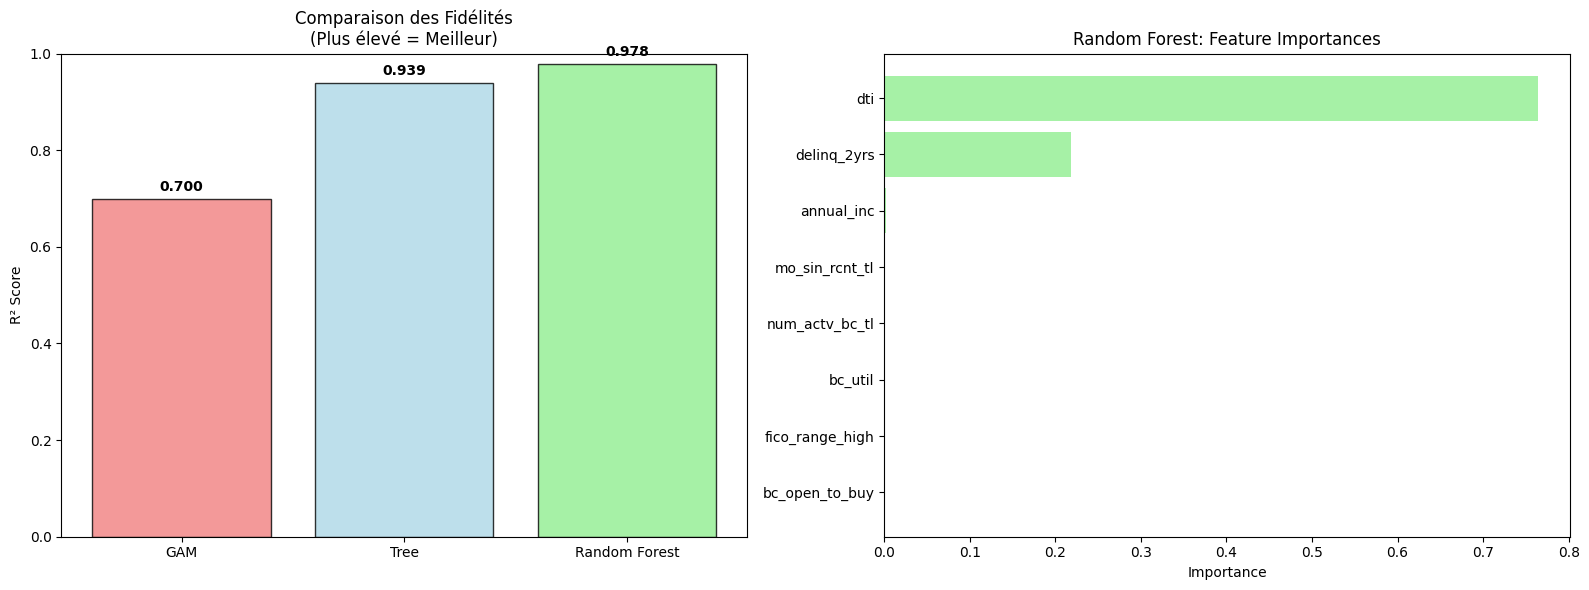


✅ SUCCÈS: Random Forest atteint R² = 0.9784 (>0.6)
   → Random Forest est un meilleur surrogate que GAM/Tree


In [24]:
# =============================================================================
# TEST D'UN SURROGATE RANDOM FOREST POUR AMÉLIORER LA FIDÉLITÉ
# =============================================================================

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

print("=" * 80)
print("TEST RANDOM FOREST SURROGATE - AMÉLIORATION DE LA FIDÉLITÉ")
print("=" * 80)

# Random Forest Surrogate
rf_surrogate = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

# Entraînement
rf_surrogate.fit(Xtr, y_train)

# Prédictions
y_train_pred_rf = rf_surrogate.predict(Xtr)
y_test_pred_rf = rf_surrogate.predict(Xte)

# Évaluation
r2_train_rf = r2_score(y_train, y_train_pred_rf)
r2_test_rf = r2_score(y_test, y_test_pred_rf)

print(f"\n📊 RÉSULTATS RANDOM FOREST SURROGATE:")
print(f"   - R² Train: {r2_train_rf:.4f}")
print(f"   - R² Test:  {r2_test_rf:.4f}")
print(f"   - Overfitting: {r2_train_rf - r2_test_rf:.4f}")

# Comparaison avec GAM et Tree
print(f"\n🔄 COMPARAISON DES FIDÉLITÉS:")
print(f"   - GAM R²:     {r2_test:.4f}")
print(f"   - Tree R²:    {r2_test_tree:.4f}")
print(f"   - Random Forest R²: {r2_test_rf:.4f}")

# Amélioration
gam_improvement = r2_test_rf - r2_test
tree_improvement = r2_test_rf - r2_test_tree

print(f"\n📈 AMÉLIORATION:")
print(f"   - vs GAM: {gam_improvement:+.4f} ({gam_improvement/r2_test*100:+.1f}%)")
print(f"   - vs Tree: {tree_improvement:+.4f} ({tree_improvement/r2_test_tree*100:+.1f}%)")

# Analyse des importances
rf_importances = rf_surrogate.feature_importances_
rf_importance_pairs = [(name, imp) for name, imp in zip(all_feature_names, rf_importances)]
rf_importance_pairs.sort(key=lambda x: x[1], reverse=True)

print(f"\n🔍 TOP 10 VARIABLES IMPORTANTES (Random Forest):")
for i, (name, imp) in enumerate(rf_importance_pairs[:10], 1):
    print(f"   {i:2d}. {name:<25} : {imp:.4f}")

# Visualisation comparative
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# R² Comparison
models = ['GAM', 'Tree', 'Random Forest']
r2_values = [r2_test, r2_test_tree, r2_test_rf]
colors = ['lightcoral', 'lightblue', 'lightgreen']

bars = ax1.bar(models, r2_values, color=colors, alpha=0.8, edgecolor='black')
ax1.set_ylabel('R² Score')
ax1.set_title('Comparaison des Fidélités\n(Plus élevé = Meilleur)')
ax1.set_ylim(0, 1)

for bar, value in zip(bars, r2_values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

# Feature Importances Comparison
top_features = [name for name, _ in rf_importance_pairs[:8]]
rf_imps = [imp for _, imp in rf_importance_pairs[:8]]

y_pos = np.arange(len(top_features))
ax2.barh(y_pos, rf_imps, color='lightgreen', alpha=0.8)
ax2.set_yticks(y_pos)
ax2.set_yticklabels(top_features)
ax2.invert_yaxis()
ax2.set_title('Random Forest: Feature Importances')
ax2.set_xlabel('Importance')

plt.tight_layout()
plt.show()

# Conclusion
if r2_test_rf > 0.6:
    print(f"\n✅ SUCCÈS: Random Forest atteint R² = {r2_test_rf:.4f} (>0.6)")
    print(f"   → Random Forest est un meilleur surrogate que GAM/Tree")
elif r2_test_rf > 0.4:
    print(f"\n⚠️  AMÉLIORATION: Random Forest atteint R² = {r2_test_rf:.4f} (0.4-0.6)")
    print(f"   → Random Forest est meilleur mais encore limité")
else:
    print(f"\n❌ ÉCHEC: Random Forest atteint seulement R² = {r2_test_rf:.4f} (<0.4)")
    print(f"   → Le black-box XGBoost est très difficile à approximer")


GLOBAL DECISION TREE VISUALIZATION


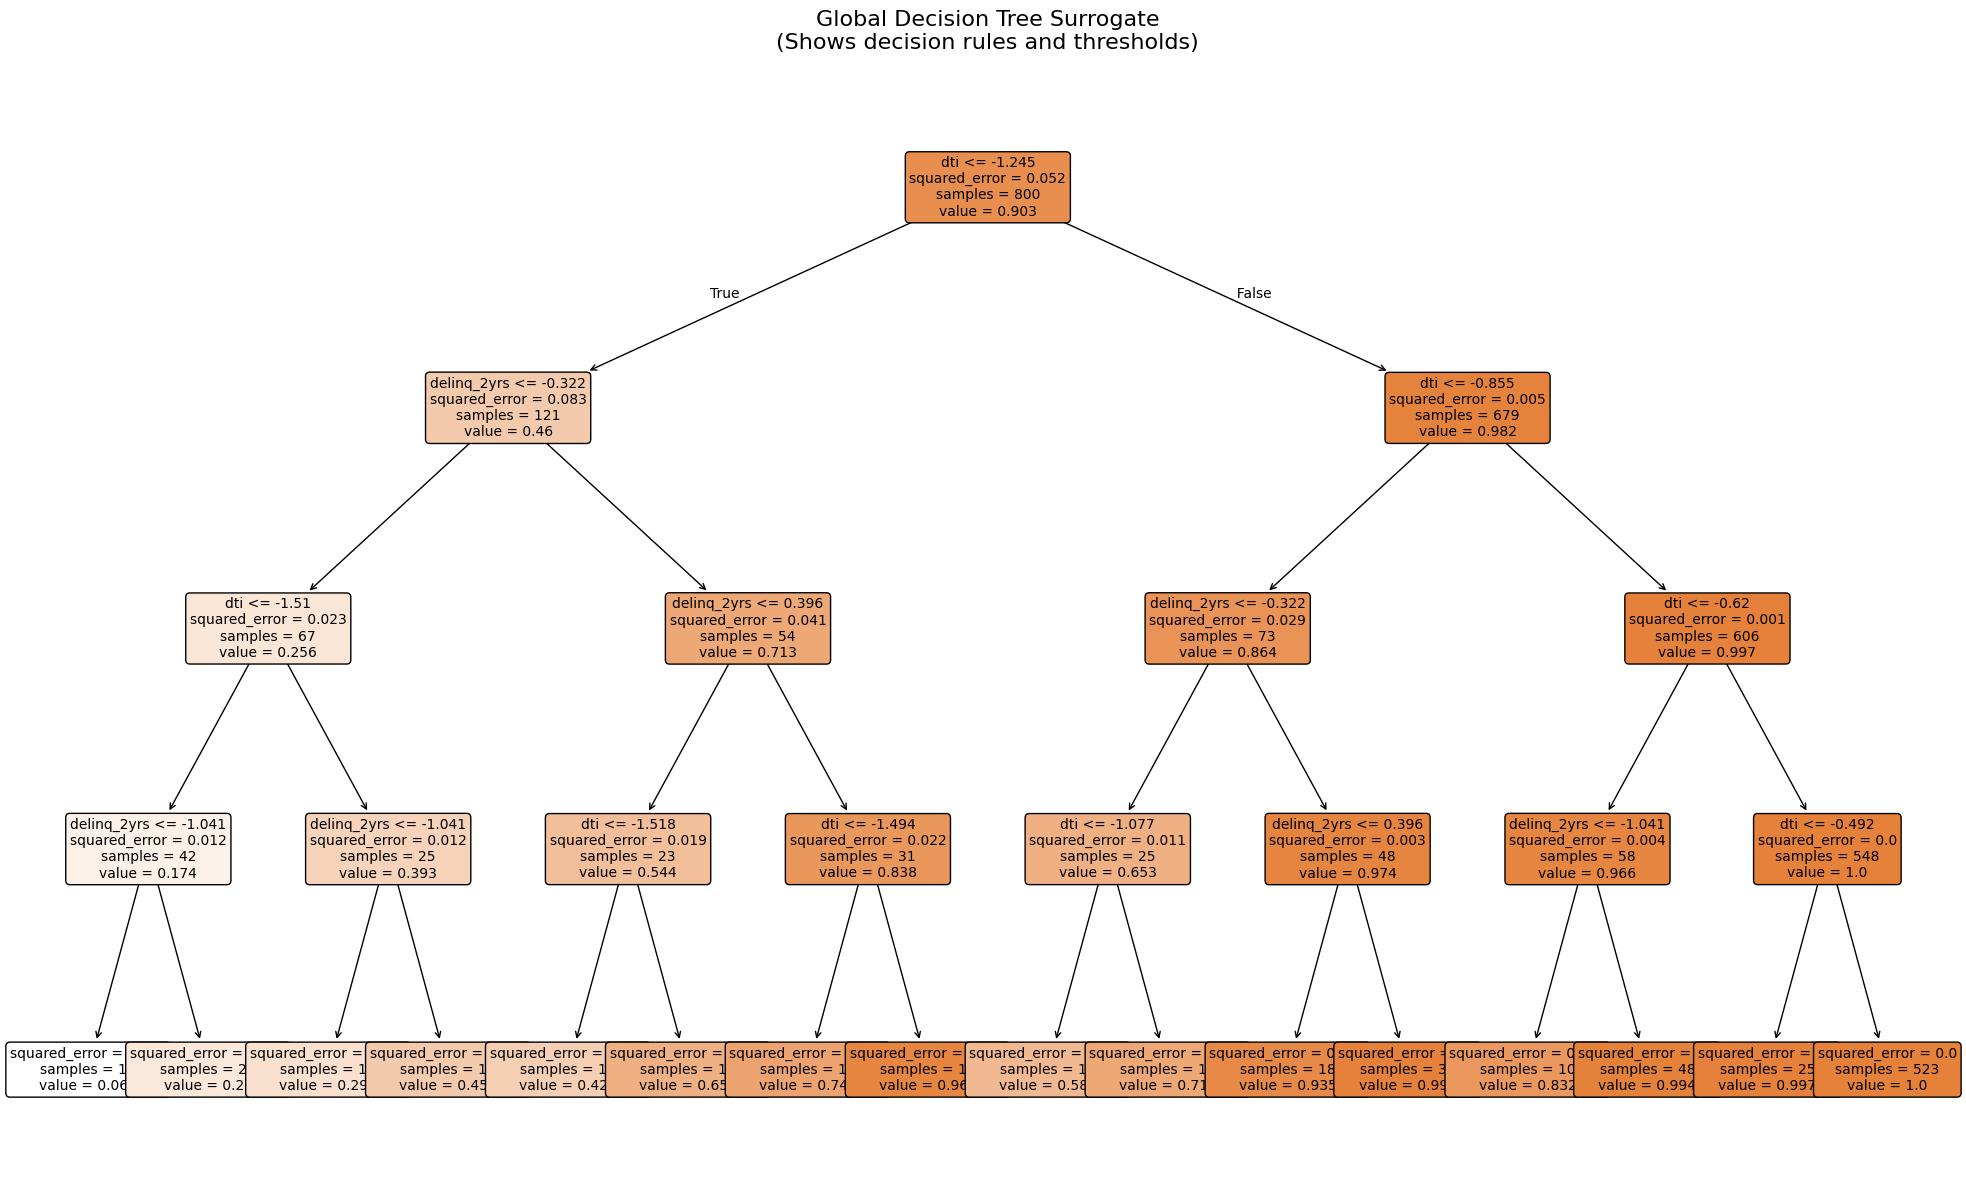

Tree Structure Summary:
- Max depth: 4
- Number of leaves: 16
- Number of nodes: 31

Decision paths for first 3 test samples:
Sample 1: Leaf 29, Prediction: 0.9970
Sample 2: Leaf 23, Prediction: 0.9973
Sample 3: Leaf 30, Prediction: 1.0000


In [25]:
# =============================================================================
# VISUALISATION DE L'ARBRE DE DÉCISION GLOBAL
# =============================================================================

from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

print("=" * 60)
print("GLOBAL DECISION TREE VISUALIZATION")
print("=" * 60)

# Create a large figure for the tree
plt.figure(figsize=(20, 12))

# Plot the decision tree
plot_tree(
    tree_surrogate,
    feature_names=tree_feature_names,
    class_names=None,  # Regression tree
    filled=True,
    rounded=True,
    fontsize=10,
    max_depth=4  # Show full tree
)

plt.title("Global Decision Tree Surrogate\n(Shows decision rules and thresholds)", 
          fontsize=16, pad=20)
plt.tight_layout()
plt.show()

# Print tree structure summary
print(f"Tree Structure Summary:")
print(f"- Max depth: {tree_surrogate.get_depth()}")
print(f"- Number of leaves: {tree_surrogate.get_n_leaves()}")
print(f"- Number of nodes: {tree_surrogate.tree_.node_count}")

# Show decision path for a few examples
print(f"\nDecision paths for first 3 test samples:")
for i in range(min(3, len(Xte))):
    path = tree_surrogate.decision_path(Xte[i:i+1]).toarray()[0]
    leaf_id = tree_surrogate.apply(Xte[i:i+1])[0]
    prediction = tree_surrogate.predict(Xte[i:i+1])[0]
    print(f"Sample {i+1}: Leaf {leaf_id}, Prediction: {prediction:.4f}")



In [26]:
# COMPARAISON COMPLÈTE : GAM vs TREE SURROGATES

print("COMPREHENSIVE COMPARISON: GAM vs TREE SURROGATES")

# 1. FIDELITY COMPARISON
print("\n1. FIDELITY COMPARISON (R²)")
print("-" * 50)
print(f"{'Metric':<20} {'GAM':<12} {'Tree':<12} {'Difference':<12}")
print("-" * 50)
print(f"{'Train R²':<20} {r2_train:<12.4f} {r2_train_tree:<12.4f} {r2_train - r2_train_tree:<12.4f}")
print(f"{'Test R²':<20} {r2_test:<12.4f} {r2_test_tree:<12.4f} {r2_test - r2_test_tree:<12.4f}")
print(f"{'Overfitting':<20} {r2_train - r2_test:<12.4f} {r2_train_tree - r2_test_tree:<12.4f} {'-'*12}")

# 2. TOP FEATURES COMPARISON
print(f"\n2. TOP FEATURES COMPARISON")
print("-" * 50)
print("GAM Top 5 (Permutation):")
for i, (name, imp) in enumerate(zip(np.array(all_feature_names)[idx[:5]], importances[idx[:5]])):
    print(f"  {i+1}. {name:<25} : {imp:.4f}")

print("\nTree Top 5 (Feature Importance):")
for i, (name, imp) in enumerate(top_tree_features[:5]):
    print(f"  {i+1}. {name:<25} : {imp:.4f}")

# 3. EFFECT TYPES COMPARISON
print(f"\n3. EFFECT TYPES COMPARISON")
print("-" * 50)
print("GAM Effects:")
print("  - Smooth non-linear curves (splines)")
print("  - Captures complex interactions")
print("  - Continuous relationships")
print("  - Partial dependence shows gradual changes")

print("\nTree Effects:")
print("  - Discrete threshold-based rules")
print("  - Step functions with clear cutoffs")
print("  - Hierarchical decision logic")
print("  - Easy to interpret business rules")

# 4. INTERPRETABILITY COMPARISON
print(f"\n4. INTERPRETABILITY COMPARISON")
print("-" * 50)
print("GAM Strengths:")
print("  ✓ Smooth, continuous effects")
print("  ✓ Captures non-linear relationships")
print("  ✓ Partial dependence plots")
print("  ✗ Less intuitive for business users")

print("\nTree Strengths:")
print("  ✓ Clear decision rules")
print("  ✓ Easy to explain to stakeholders")
print("  ✓ Hierarchical logic")
print("  ✗ Discretizes continuous effects")

# 5. BUSINESS INSIGHTS
print(f"\n5. BUSINESS INSIGHTS")
print("-" * 50)
print("GAM reveals:")
print("  - Smooth threshold effects (e.g., emp_length_2_years)")
print("  - U-shaped relationships (e.g., dti)")
print("  - Complex non-linear patterns")

print("\nTree reveals:")
print("  - Clear decision boundaries")
print("  - Hierarchical feature importance")
print("  - Business rules for decision making")

print("\n" + "=" * 80)
print("CONCLUSION: Both surrogates provide complementary insights!")
print("GAM: Complex patterns, smooth effects")
print("Tree: Clear rules, business logic")
print("=" * 80)


COMPREHENSIVE COMPARISON: GAM vs TREE SURROGATES

1. FIDELITY COMPARISON (R²)
--------------------------------------------------
Metric               GAM          Tree         Difference  
--------------------------------------------------
Train R²             0.8457       0.9733       -0.1275     
Test R²              0.6998       0.9391       -0.2393     
Overfitting          0.1460       0.0342       ------------

2. TOP FEATURES COMPARISON
--------------------------------------------------
GAM Top 5 (Permutation):
  1. dti                       : 1.4393
  2. delinq_2yrs               : 0.1804
  3. grade_C                   : 0.0062
  4. sub_grade_A1              : 0.0061
  5. annual_inc                : 0.0048

Tree Top 5 (Feature Importance):
  1. dti                       : 0.7586
  2. delinq_2yrs               : 0.2414
  3. issue_d                   : 0.0000
  4. loan duration             : 0.0000
  5. annual_inc                : 0.0000

3. EFFECT TYPES COMPARISON
--------------